# Separating Variance by Scale

This notebook will be used to explore separating variance of density and spice by different scales. In particular, I'll start with examining Dhruv's ratio method of comparing density and spice, which is outlined in more detail below.

In [2]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft

import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df
import funcs

In [230]:
reload(ff)
reload(ef)
reload(pf)
reload(df)
reload(funcs)

<module 'funcs' from '/home.ufs/amf2288/argo-intern/funcs.py'>

## Profile Selection

In [297]:
box_z = xr.open_dataset('202206_boxes/lon:(-60,-50)_lat:(-60,-55)_ds_z.nc')

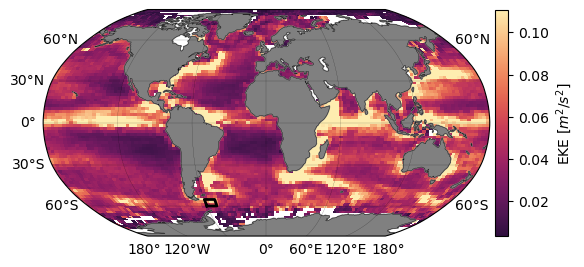

In [298]:
pf.plot_box([[-60,-50,-60,-55]])

I'm picking these three to test out because they exhibit different qualities:
- Black seems to show a very similar profile to density, but has more wiggles between ~400-800m
- Blue shows wiggles near the surface, but they fade by ~500m, below which it's very smooth
- Red is interesting because it has much more wiggle than density, with little large-scale change

In [301]:
i = 90
j = 20
k = 100

i_prof_SIG0  = box_z.isel(N_PROF=i).SIG0
i_prof_SPICE = box_z.isel(N_PROF=i).SPICE

j_prof_SIG0  = box_z.isel(N_PROF=j).SIG0
j_prof_SPICE = box_z.isel(N_PROF=j).SPICE

k_prof_SIG0  = box_z.isel(N_PROF=k).SIG0
k_prof_SPICE = box_z.isel(N_PROF=k).SPICE

i_spec_SIG0  = xrft.power_spectrum(i_prof_SIG0,  dim='PRES_INTERPOLATED', window='hamming')
i_spec_SPICE = xrft.power_spectrum(i_prof_SPICE, dim='PRES_INTERPOLATED', window='hamming')

j_spec_SIG0  = xrft.power_spectrum(j_prof_SIG0,  dim='PRES_INTERPOLATED', window='hamming')
j_spec_SPICE = xrft.power_spectrum(j_prof_SPICE, dim='PRES_INTERPOLATED', window='hamming')

k_spec_SIG0  = xrft.power_spectrum(k_prof_SIG0,  dim='PRES_INTERPOLATED', window='hamming')
k_spec_SPICE = xrft.power_spectrum(k_prof_SPICE, dim='PRES_INTERPOLATED', window='hamming')

Text(0.5, 1.0, 'Spice Spectra')

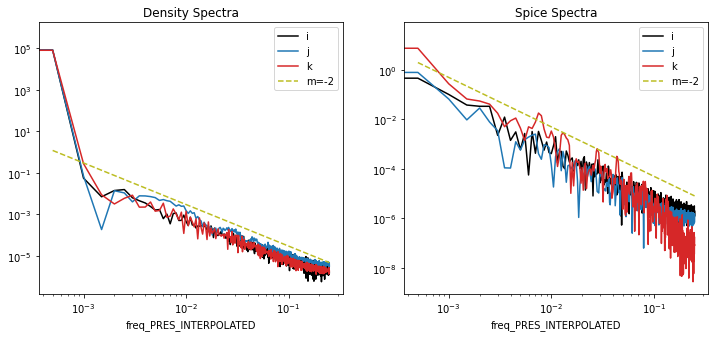

In [437]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
i_spec_SIG0.plot(color=bk, label='i')
j_spec_SIG0.plot(color=be, label='j')
k_spec_SIG0.plot(color=rd, label='k')

m=k_spec_SIG0.freq_PRES_INTERPOLATED
plt.plot(m, 3e-7*m**(-2),'--',color='tab:olive',label='m=-2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Density Spectra')


plt.subplot(1,2,2)
i_spec_SPICE.plot(color=bk, label='i')
j_spec_SPICE.plot(color=be, label='j')
k_spec_SPICE.plot(color=rd, label='k')

m=k_spec_SPICE.freq_PRES_INTERPOLATED
plt.plot(m, 5e-7*m**(-2),'--',color='tab:olive',label='m=-2')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spice Spectra')

BOTH: I'm a bit suspicious of my methods since both plots have a slope right at -2, although I set window='hamming'. Anyway, I'm not totally sure if these plots are valid for interpretation.

DENSITY: This is interesting because they all look so similar. I think I would've expected red to have lower large-scale variance because there is not a sharp transition at and just below the mixed layer, unlike the blue profile especially.

SPICE: So initially I thought the left side was large-scale variance and the right was small-scale. But that would mean the trends are exactly opposite to what I expect: I thought red would have the least large-scale and most small scale for spice, and blue/black would be reversed. So now I'm wondering if I got the x-axis meaning reversed in my head. 

UPDATE: From talking with Dhruv, there's much more nuance here than I was noticing at first. For the spice spectra, there seem to be small peaks in the red profile above and below 100m, which could be where the smallest scale variance shows up. I was looking for peaks at much smaller scales (which here is just a few meters) and there may be more noise than signal at that scale.

## Exclusive Ratio, R_{ex}

One unresolved issue is how to interpret the results of a Steinberg-style variance approach to analyzing the spice signal. More specifically, it may not be clear if variance is due to isopycnal heave (which we want to remove) or along isopycnal stirring (which we want to study). One idea is to look at the ratio between small and large-scale spice variance in both density and spice profiles. We would expect spice to have a larger ratio than density generally, but maybe by looking at how these ratios change spatially we can narrow down where isopycnal heave does and does not influence our interpretation.

In [303]:
l1 = 100
l2 = 200
l3 = 400

MKE1_d = ef.get_MV(box_z,l1,variable='SIG0')
MKE2_d = ef.get_MV(box_z,l2,variable='SIG0')
MKE3_d = ef.get_MV(box_z,l3,variable='SIG0')

MKE1_s = ef.get_MV(box_z,l1,variable='SPICE')
MKE2_s = ef.get_MV(box_z,l2,variable='SPICE')
MKE3_s = ef.get_MV(box_z,l3,variable='SPICE')

EKE1_d = ef.get_EV(box_z,l1,variable='SIG0')
EKE2_d = ef.get_EV(box_z,l2,variable='SIG0')
EKE3_d = ef.get_EV(box_z,l3,variable='SIG0')

EKE1_s = ef.get_EV(box_z,l1,variable='SPICE')
EKE2_s = ef.get_EV(box_z,l2,variable='SPICE')
EKE3_s = ef.get_EV(box_z,l3,variable='SPICE')

In [304]:
MKE0_vd = EKE1_d
MKE1_vd = MKE1_d - MKE2_d
MKE2_vd = MKE2_d - MKE3_d
MKE3_vd = MKE3_d

MKE0_vs = EKE1_s
MKE1_vs = MKE1_s - MKE2_s
MKE2_vs = MKE2_s - MKE3_s
MKE3_vs = MKE3_s

EKE0_vd = EKE1_d
EKE1_vd = EKE2_d - EKE1_d
EKE2_vd = EKE3_d - EKE2_d
EKE3_vd = MKE3_d

EKE0_vs = EKE1_s
EKE1_vs = EKE2_s - EKE1_s
EKE2_vs = EKE3_s - EKE2_s
EKE3_vs = MKE3_s

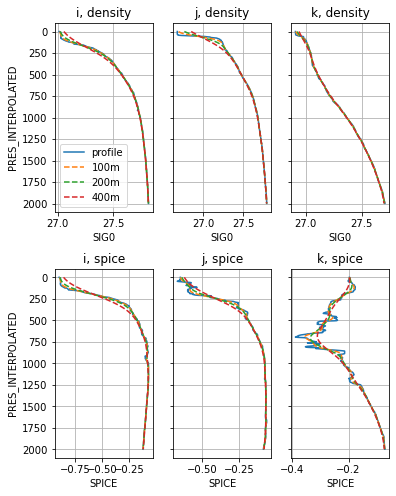

In [435]:
plt.figure(figsize=(6,8))

plt.subplot(2,3,1)
i_prof_SIG0.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(i_prof_SIG0,l1), box_z.PRES_INTERPOLATED,'--',label='{}m'.format(l1))
plt.plot(ff.get_filt_prof(i_prof_SIG0,l2), box_z.PRES_INTERPOLATED,'--',label='{}m'.format(l2))
plt.plot(ff.get_filt_prof(i_prof_SIG0,l3), box_z.PRES_INTERPOLATED,'--',label='{}m'.format(l3))
plt.gca().invert_yaxis()
plt.legend()
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.grid()
plt.title('i, density')

plt.subplot(2,3,2)
j_prof_SIG0.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(j_prof_SIG0,l1), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(j_prof_SIG0,l2), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(j_prof_SIG0,l3), box_z.PRES_INTERPOLATED,'--')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(range(0,2001,250),())
plt.grid()
plt.title('j, density')

plt.subplot(2,3,3)
k_prof_SIG0.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(k_prof_SIG0,l1), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(k_prof_SIG0,l2), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(k_prof_SIG0,l3), box_z.PRES_INTERPOLATED,'--')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(range(0,2001,250),())
plt.grid()
plt.title('k, density')

plt.subplot(2,3,4)
i_prof_SPICE.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(i_prof_SPICE,l1), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(i_prof_SPICE,l2), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(i_prof_SPICE,l3), box_z.PRES_INTERPOLATED,'--')
plt.gca().invert_yaxis()
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.grid()
plt.title('i, spice')

plt.subplot(2,3,5)
j_prof_SPICE.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(j_prof_SPICE,l1), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(j_prof_SPICE,l2), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(j_prof_SPICE,l3), box_z.PRES_INTERPOLATED,'--')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(range(0,2001,250),())
plt.grid()
plt.title('j, spice')

plt.subplot(2,3,6)
k_prof_SPICE.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(k_prof_SPICE,l1), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(k_prof_SPICE,l2), box_z.PRES_INTERPOLATED,'--')
plt.plot(ff.get_filt_prof(k_prof_SPICE,l3), box_z.PRES_INTERPOLATED,'--')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.yticks(range(0,2001,250),())
plt.grid()
plt.title('k, spice')

plt.subplots_adjust(hspace=0.3)

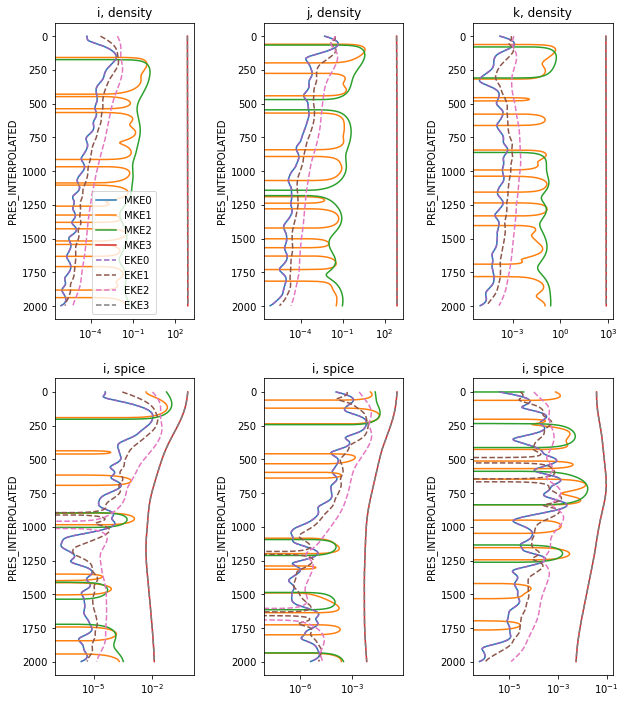

In [329]:
plt.figure(figsize=(10,12))

plt.subplot(2,3,1)7
MKE0_vd.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',label='MKE0')
MKE1_vd.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',label='MKE1')
MKE2_vd.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',label='MKE2')
MKE3_vd.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',label='MKE3')
EKE0_vd.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0')
EKE1_vd.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1')
EKE2_vd.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2')
EKE3_vd.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3')
plt.gca().invert_yaxis()
plt.legend()
plt.xscale('log')
plt.title('i, density')

plt.subplot(2,3,2)
MKE0_vd.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',label='MKE0')
MKE1_vd.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',label='MKE1')
MKE2_vd.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',label='MKE2')
MKE3_vd.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',label='MKE3')
EKE0_vd.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0')
EKE1_vd.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1')
EKE2_vd.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2')
EKE3_vd.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('j, density')

plt.subplot(2,3,3)
MKE0_vd.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',label='MKE0')
MKE1_vd.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',label='MKE1')
MKE2_vd.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',label='MKE2')
MKE3_vd.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',label='MKE3')
EKE0_vd.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0')
EKE1_vd.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1')
EKE2_vd.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2')
EKE3_vd.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('k, density')

plt.subplot(2,3,4)
MKE0_vs.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',label='MKE0')
MKE1_vs.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',label='MKE1')
MKE2_vs.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',label='MKE2')
MKE3_vs.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',label='MKE3')
EKE0_vs.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0')
EKE1_vs.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1')
EKE2_vs.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2')
EKE3_vs.isel(N_PROF=i).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('i, spice')

plt.subplot(2,3,5)
MKE0_vs.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',label='MKE0')
MKE1_vs.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',label='MKE1')
MKE2_vs.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',label='MKE2')
MKE3_vs.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',label='MKE3')
EKE0_vs.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0')
EKE1_vs.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1')
EKE2_vs.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2')
EKE3_vs.isel(N_PROF=j).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('i, spice')

plt.subplot(2,3,6)
MKE0_vs.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',label='MKE0')
MKE1_vs.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',label='MKE1')
MKE2_vs.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',label='MKE2')
MKE3_vs.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',label='MKE3')
EKE0_vs.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0')
EKE1_vs.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1')
EKE2_vs.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2')
EKE3_vs.isel(N_PROF=k).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.title('i, spice')

plt.subplots_adjust(wspace=0.5)

In [330]:
i_R_d = EKE0_vd.isel(N_PROF=i).sum(dim='PRES_INTERPOLATED')  / MKE3_vd.isel(N_PROF=i).sum(dim='PRES_INTERPOLATED')
i_R_s = EKE0_vs.isel(N_PROF=i).sum(dim='PRES_INTERPOLATED')  / MKE3_vs.isel(N_PROF=i).sum(dim='PRES_INTERPOLATED')

j_R_d = EKE0_vd.isel(N_PROF=j).sum(dim='PRES_INTERPOLATED')  / MKE3_vd.isel(N_PROF=j).sum(dim='PRES_INTERPOLATED')
j_R_s = EKE0_vs.isel(N_PROF=j).sum(dim='PRES_INTERPOLATED')  / MKE3_vs.isel(N_PROF=j).sum(dim='PRES_INTERPOLATED')

k_R_d = EKE0_vd.isel(N_PROF=k).sum(dim='PRES_INTERPOLATED')  / MKE3_vd.isel(N_PROF=k).sum(dim='PRES_INTERPOLATED')
k_R_s = EKE0_vs.isel(N_PROF=k).sum(dim='PRES_INTERPOLATED')  / MKE3_vs.isel(N_PROF=k).sum(dim='PRES_INTERPOLATED')

In [404]:
from tabulate import tabulate

Ratios = [['Profile', 'R_rho', 'R_s'], ['i', i_R_d.values,i_R_s.values], 
          ['j', j_R_d.values,j_R_s.values], ['k', k_R_d.values,k_R_s.values]]
print(tabulate(Ratios))

-------  ----------------------  --------------------
Profile  R_rho                   R_s
i        5.714460475655798e-07   0.00991576802490027
j        2.30801431234455e-06    0.008290041553450995
k        2.3406756006316102e-07  0.005044214506000648
-------  ----------------------  --------------------


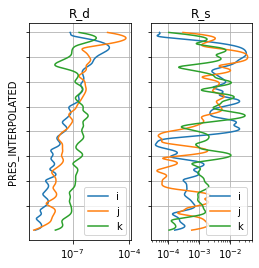

In [427]:
plt.figure(figsize=(4,4))

plt.subplot(1,2,1)
(EKE0_vd.isel(N_PROF=i) / MKE3_vd.isel(N_PROF=i)).plot(y='PRES_INTERPOLATED',label='i')
(EKE0_vd.isel(N_PROF=j) / MKE3_vd.isel(N_PROF=j)).plot(y='PRES_INTERPOLATED',label='j')
(EKE0_vd.isel(N_PROF=k) / MKE3_vd.isel(N_PROF=k)).plot(y='PRES_INTERPOLATED',label='k')
plt.gca().invert_yaxis()
plt.legend()
plt.yticks(range(0,2000,250),())
plt.grid()
plt.title('R_d')
plt.xscale('log')

plt.subplot(1,2,2)
(EKE0_vs.isel(N_PROF=i) / MKE3_vs.isel(N_PROF=i)).plot(y='PRES_INTERPOLATED',label='i')
(EKE0_vs.isel(N_PROF=j) / MKE3_vs.isel(N_PROF=j)).plot(y='PRES_INTERPOLATED',label='j')
(EKE0_vs.isel(N_PROF=k) / MKE3_vs.isel(N_PROF=k)).plot(y='PRES_INTERPOLATED',label='k')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('')
plt.yticks(range(0,2000,250),())
plt.grid()
plt.title('R_s')
plt.xscale('log');

## Partition Ratio, R_{part}

Maybe this method isn't the best to capture the ratio of variance between scales since each set of profiles will probably have different peaks in different regions (based on the spectra). Insttead, we could chose a ratio closer to a Steinberg style analysis that compares variance on either side (greater than or less than) one single scale. This would look like:

$R_{steinberg} = EKE / MKE $

$R_{steinberg} = (\langle u^{2} \rangle _{l} - \langle u \rangle _{l}^{2}) \hspace{0.25cm} / \hspace{0.25cm} \langle u \rangle_{l}^{2}$

In [409]:
EV_l1_d = ef.get_EV(box_z,l1,variable='SIG0')
MV_l1_d = ef.get_MV(box_z,l1,variable='SIG0')

EV_l2_d = ef.get_EV(box_z,l2,variable='SIG0')
MV_l2_d = ef.get_MV(box_z,l2,variable='SIG0')

EV_l3_d = ef.get_EV(box_z,l3,variable='SIG0')
MV_l3_d = ef.get_MV(box_z,l3,variable='SIG0')


EV_l1_s = ef.get_EV(box_z,l1,variable='SPICE')
MV_l1_s = ef.get_MV(box_z,l1,variable='SPICE')

EV_l2_s = ef.get_EV(box_z,l2,variable='SPICE')
MV_l2_s = ef.get_MV(box_z,l2,variable='SPICE')

EV_l3_s = ef.get_EV(box_z,l3,variable='SPICE')
MV_l3_s = ef.get_MV(box_z,l3,variable='SPICE')

In [410]:
i_R_l1_d = EV_l1_d.isel(N_PROF=i) / MV_l1_d.isel(N_PROF=i)
i_R_l2_d = EV_l2_d.isel(N_PROF=i) / MV_l2_d.isel(N_PROF=i)
i_R_l3_d = EV_l3_d.isel(N_PROF=i) / MV_l3_d.isel(N_PROF=i)

j_R_l1_d = EV_l1_d.isel(N_PROF=j) / MV_l1_d.isel(N_PROF=j)
j_R_l2_d = EV_l2_d.isel(N_PROF=j) / MV_l2_d.isel(N_PROF=j)
j_R_l3_d = EV_l3_d.isel(N_PROF=j) / MV_l3_d.isel(N_PROF=j)

k_R_l1_d = EV_l1_d.isel(N_PROF=k) / MV_l1_d.isel(N_PROF=k)
k_R_l2_d = EV_l2_d.isel(N_PROF=k) / MV_l2_d.isel(N_PROF=k)
k_R_l3_d = EV_l3_d.isel(N_PROF=k) / MV_l3_d.isel(N_PROF=k)


i_R_l1_s = EV_l1_s.isel(N_PROF=i) / MV_l1_s.isel(N_PROF=i)
i_R_l2_s = EV_l2_s.isel(N_PROF=i) / MV_l2_s.isel(N_PROF=i)
i_R_l3_s = EV_l3_s.isel(N_PROF=i) / MV_l3_s.isel(N_PROF=i)

j_R_l1_s = EV_l1_s.isel(N_PROF=j) / MV_l1_s.isel(N_PROF=j)
j_R_l2_s = EV_l2_s.isel(N_PROF=j) / MV_l2_s.isel(N_PROF=j)
j_R_l3_s = EV_l3_s.isel(N_PROF=j) / MV_l3_s.isel(N_PROF=j)

k_R_l1_s = EV_l1_s.isel(N_PROF=k) / MV_l1_s.isel(N_PROF=k)
k_R_l2_s = EV_l2_s.isel(N_PROF=k) / MV_l2_s.isel(N_PROF=k)
k_R_l3_s = EV_l3_s.isel(N_PROF=k) / MV_l3_s.isel(N_PROF=k)

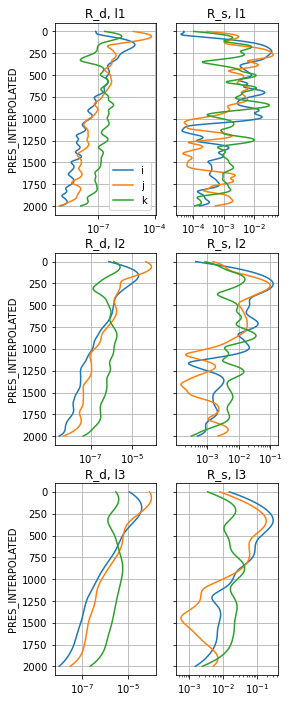

In [428]:
plt.figure(figsize=(4,12))

plt.subplot(3,2,1)
i_R_l1_d.plot(y='PRES_INTERPOLATED',label='i')
j_R_l1_d.plot(y='PRES_INTERPOLATED',label='j')
k_R_l1_d.plot(y='PRES_INTERPOLATED',label='k')
plt.gca().invert_yaxis()
plt.legend()
plt.xscale('log')
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.grid()
plt.title('R_d, l1')

plt.subplot(3,2,2)
i_R_l1_s.plot(y='PRES_INTERPOLATED',label='i')
j_R_l1_s.plot(y='PRES_INTERPOLATED',label='j')
k_R_l1_s.plot(y='PRES_INTERPOLATED',label='k')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.ylabel('')
plt.yticks(range(0,2001,250),())
plt.grid()
plt.title('R_s, l1')

plt.subplot(3,2,3)
i_R_l2_d.plot(y='PRES_INTERPOLATED',label='i')
j_R_l2_d.plot(y='PRES_INTERPOLATED',label='j')
k_R_l2_d.plot(y='PRES_INTERPOLATED',label='k')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.grid()
plt.title('R_d, l2')

plt.subplot(3,2,4)
i_R_l2_s.plot(y='PRES_INTERPOLATED',label='i')
j_R_l2_s.plot(y='PRES_INTERPOLATED',label='j')
k_R_l2_s.plot(y='PRES_INTERPOLATED',label='k')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.ylabel('')
plt.yticks(range(0,2001,250),())
plt.grid()
plt.title('R_s, l2')

plt.subplot(3,2,5)
i_R_l3_d.plot(y='PRES_INTERPOLATED',label='i')
j_R_l3_d.plot(y='PRES_INTERPOLATED',label='j')
k_R_l3_d.plot(y='PRES_INTERPOLATED',label='k')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.grid()
plt.title('R_d, l3')

plt.subplot(3,2,6)
i_R_l3_s.plot(y='PRES_INTERPOLATED',label='i')
j_R_l3_s.plot(y='PRES_INTERPOLATED',label='j')
k_R_l3_s.plot(y='PRES_INTERPOLATED',label='k')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.ylabel('')
plt.yticks(range(0,2001,250),())
plt.grid()
plt.title('R_s, l3')

plt.subplots_adjust(hspace=0.2)